In [1]:
import os
import glob
import random
import numpy as np
import tensorflow as tf
import pandas as pd
import skimage
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
import datetime

In [2]:
FOLD_IDX = 5
ROOT_DIR = r"./dataWithPhoto/learning/fold{}/".format(FOLD_IDX)
VERSION = "v12"
TRAIN_PATH = os.path.join(ROOT_DIR, r"train/")
VALID_PATH = os.path.join(ROOT_DIR, r"test/")
VALID_PRED_PATH = os.path.join(VALID_PATH, r"pred-{}/".format(VERSION))
IMG_SHAPE = (512, 512, 3)
LBL_SHAPE = IMG_SHAPE[:2]
LOW_MEMORY = True
EXPANSION_RATE = 3

In [13]:
def dice_loss(y_true, y_pred, smooth=1.):
    intersection = tf.reduce_sum(y_true*y_pred)
    return 1-(2.*intersection)/(tf.reduce_sum(tf.square(y_true))+tf.reduce_sum(tf.square(y_pred))+smooth)

def _circle_kernel_4D(radius):
    _kernel = skimage.morphology.disk(radius, dtype=np.float32) - np.pad(skimage.morphology.disk(radius-1, dtype=np.float32), pad_width=1, mode='constant')
    return _kernel[...,None,None] / _kernel.sum()

Radii = [3,6,9,12,15,18]
Kernels_in = [_circle_kernel_4D(r) for r in Radii]

def HD_CV_loss(y_true, y_pred, kernels_in=Kernels_in, radii=Radii, alpha=2.0):
    p = y_true
    p_binary = tf.expand_dims(p, axis=-1) # 4D-tensor, shape=(1,512,512,1)
    q = tf.clip_by_value(y_pred, 0., 1.)
    q_binary = tf.expand_dims(tf.cast(tf.cast(q + 0.5, tf.int32), tf.float32), axis=-1) # 4D-tensor, shape=(1,512,512,1)
    _squared_diff_pq = tf.square(p-q)
    f_q_p = tf.expand_dims(tf.multiply(_squared_diff_pq, q), axis=-1) # 4D-tensor, shape=(1,512,512,1)
    f_p_q = tf.expand_dims(tf.multiply(_squared_diff_pq, p), axis=-1) # 4D-tensor, shape=(1,512,512,1)
    kernels = [tf.constant(k_in,dtype=tf.float32) for k_in in kernels_in]
    loss_hd = 0.
    for r,ker in zip(radii,kernels):
        _out1 = tf.multiply(tf.nn.conv2d(1.-p_binary, ker, strides=1, padding="SAME"), f_q_p)
        _out2 = tf.multiply(tf.nn.conv2d(p_binary, ker, strides=1, padding="SAME"), f_p_q)
        _out3 = tf.multiply(tf.nn.conv2d(1.-q_binary, ker, strides=1, padding="SAME"), f_p_q)
        _out4 = tf.multiply(tf.nn.conv2d(q_binary, ker, strides=1, padding="SAME"), f_q_p)
        loss_hd += r**alpha * tf.reduce_mean(_out1+_out2+_out3+_out4)
    return loss_hd

def _gaussuian_kernel_4D(kernel_size, sigma=1):
    x, y = np.meshgrid(np.linspace(-1, 1, kernel_size),
                       np.linspace(-1, 1, kernel_size))
    _gauss = np.exp(-((x**2+y**2) / (2.0 * sigma**2)))
    return _gauss[...,None,None] / _gauss.sum()

def SSIM_loss(y_true, y_pred):
    c1 = 1.
    c2 = 1.
    p = tf.expand_dims(y_true, axis=-1) # 4D-tensor, shape=(1,512,512,1) for Conv2D
    q = tf.expand_dims(y_pred, axis=-1)
    ker = _gaussuian_kernel_4D(kernel_size=11, sigma=1.5)
    mu_p = tf.nn.conv2d(p, ker, strides=1, padding="VALID")
    mu_q = tf.nn.conv2d(q, ker, strides=1, padding="VALID")
    mu2_p = tf.square(mu_p) 
    mu2_q = tf.square(mu_q)
    mu_pq = tf.multiply(mu_p,mu_q)
    sigma2_p = tf.nn.conv2d(tf.square(p), ker, strides=1, padding="VALID") - mu2_p
    sigma2_q = tf.nn.conv2d(tf.square(q), ker, strides=1, padding="VALID") - mu2_q
    sigma_pq = tf.nn.conv2d(tf.multiply(p,q), ker, strides=1, padding="VALID") - mu_pq
    return 1.-tf.reduce_mean((2. * mu_pq + c1) * (2. * sigma_pq + c2) / ((mu2_p + mu2_q + c1) * (sigma2_p + sigma2_q + c2)))

bce_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

HD_Weight = 0.01
BCE_Weight = 0.5
SSMI_Weight = 1.

def Dice_HD_compound_loss(y_true, y_pred, HD_Weight=HD_Weight):
    return dice_loss(y_true, y_pred, smooth=1.) + HD_Weight * HD_CV_loss(y_true, y_pred, kernels_in=Kernels_in, radii=Radii, alpha=2.0)

def Dice_BCE_compound_loss(y_true, y_pred, BCE_Weight=BCE_Weight):
    return dice_loss(y_true, y_pred, smooth=1.) + BCE_Weight * bce_loss(y_true, y_pred)

def Dice_HD_BCE_compound_loss(y_true, y_pred, HD_Weight=HD_Weight, BCE_Weight=BCE_Weight):
    return dice_loss(y_true, y_pred, smooth=1.) + HD_Weight * HD_CV_loss(y_true, y_pred, kernels_in=Kernels_in, radii=Radii, alpha=2.0) + BCE_Weight * bce_loss(y_true, y_pred)

def BCE_SSMI_loss(y_true, y_pred, SSMI_Weight=SSMI_Weight):
    return bce_loss(y_true, y_pred) + SSMI_Weight * SSIM_loss(y_true, y_pred)

In [14]:
def read_data(parent_dir):
    file_list = glob.glob(os.path.join(parent_dir, 'image', '*.png'))
    image_list = []
    label_list = []
    for file_path in file_list:
        label_path = os.path.join(parent_dir, 'label', os.path.basename(file_path))
        image_list.append(skimage.io.imread(file_path))
        label_list.append(skimage.io.imread(label_path))
    return image_list, label_list

def get_data_filenames(parent_dir):
    image_filename_list = glob.glob(os.path.join(parent_dir, 'image', '*.png'))
    label_filename_list = [os.path.join(parent_dir, 'label', os.path.basename(image_filename)) \
                          for image_filename in image_filename_list]
    return image_filename_list, label_filename_list

In [15]:
def min_max_scale_image(img):
    assert img.ndim == 3, "Input requires an RGB image"
    _max_val = np.max(img, axis=(0,1))
    _min_val = np.min(img, axis=(0,1))
    return (img - _min_val) / (_max_val - _min_val)

def gen_data(image, label, train=True):
    if train == True:
        # random rotation
        theta = 60 * (np.random.rand() - 0.5)
        image = skimage.transform.rotate(image, theta)
        label = skimage.transform.rotate(label, theta)
        # horizontal flip or not
        if np.random.rand() > 0.5:
            image = image[:,::-1]
            label = label[:,::-1]
    # # increase constrast
    # v_min, v_max = np.percentile(image, (0.1, 99.9))
    # image = skimage.exposure.rescale_intensity(image, in_range=(v_min, v_max))

    # resize to input shape (512,512)
    image = skimage.transform.resize(image, IMG_SHAPE)
    label = skimage.transform.resize(label, LBL_SHAPE) > 0.5
    return image, label

In [16]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, image_list, label_list, batch_size=8, train=True):
        self.batch_size = batch_size
        self.image_list = image_list
        self.label_list = label_list
        self.train = train
        self.index_cnt = len(self.image_list)
        self.index_list = list(range(self.index_cnt))
        self.on_epoch_end()
    def __len__(self):
        return self.index_cnt // self.batch_size
    def __getitem__(self, k):
        ks = k * self.batch_size
        kt = ks + self.batch_size
        x = np.empty((self.batch_size, *IMG_SHAPE), dtype='float32')
        y = np.empty((self.batch_size, *LBL_SHAPE), dtype='float32')
        for i, index in enumerate(range(ks, kt)):
            real_index = self.index_list[index]
            img = self.image_list[real_index]
            lbl = self.label_list[real_index]
            if LOW_MEMORY == True: # read from file
                img = skimage.io.imread(img)
                lbl = skimage.io.imread(lbl, as_gray=True)
            # dilation 
            lbl = skimage.morphology.dilation(lbl, skimage.morphology.disk(EXPANSION_RATE)) # dilation edge prediction for visualization
            x[i], y[i] = gen_data(img, lbl, self.train)
        return x, y
    def on_epoch_end(self):
        if self.train == True:
            np.random.shuffle(self.index_list)

In [17]:
# an almost typical U-Net 2015 (different in padding)
def LeakyConv2D(x, filters, k_size=3, leaky_rate=.1, dila=1):
    x = layers.Conv2D(filters, kernel_size=k_size, dilation_rate=dila, padding='same')(x)
    x = layers.LeakyReLU(leaky_rate)(x)
    return x

def CascadeConv2D(x, filters, conv_times, k_size=3, leaky_rate=.1, dila=1):
    for _ in range(conv_times):
        x = LeakyConv2D(x, filters, k_size, leaky_rate, dila)
    return x
        
def UNet2015(shape, kern_size=3, filters=[64,128,256,512,1024]):
    outputShape = shape[:2] # (512,512)
    encoders = []
    inp = layers.Input(shape) # (512,512,3)
    depth = 0
    x = inp
    conv_times = 2
    for f in filters[:-1]:
        x = CascadeConv2D(x, f, conv_times, kern_size, leaky_rate=.1, dila=1)
        encoders.append(x)
        x = layers.MaxPooling2D(2)(x)
        depth += 1
    x = CascadeConv2D(x, filters[-1], conv_times, kern_size, leaky_rate=.1, dila=1)
    while depth > 0 :
        depth -= 1
        f = filters[depth]
        x = layers.Conv2DTranspose(f, kernel_size=2, strides=(2, 2), padding="valid")(x)
        x = layers.Concatenate()([x, encoders.pop()])
        x = CascadeConv2D(x, f, conv_times, kern_size, leaky_rate=.1, dila=1)
    x = LeakyConv2D(x, filters=1, k_size=1, leaky_rate=.1, dila=1)
    x = layers.Reshape(outputShape)(x)
    model = keras.Model(inp, x, name='UNet-2015')
    return model




def ResidualConv2D(x, filters, conv_times=2, k_size=3, leaky_rate=.1, dila=1):
    inx = layers.Conv2D(filters, kernel_size=1, strides=1, padding='same')(x)
    for _ in range(conv_times):
        x = LeakyConv2D(x, filters, k_size, leaky_rate, dila)
    return layers.Add()([inx, x])

def ResUNet(shape, kern_size=3, filters=[64,128,256,512,1024]):
    outputShape = shape[:2] # (512,512)
    encoders = []
    inp = layers.Input(shape) # (512,512,3)
    depth = 0
    x = inp
    for f in filters[:-1]:
        x = ResidualConv2D(x, f, conv_times=2)
        encoders.append(x)
        x = layers.MaxPooling2D(2)(x)
        depth += 1
    x = ResidualConv2D(x, filters[-1], conv_times=2)
    while depth > 0 :
        depth -= 1
        f = filters[depth]
        x = layers.Conv2DTranspose(f, kernel_size=2, strides=(2, 2), padding="valid")(x)
        x = layers.Concatenate()([x, encoders.pop()])
        x = ResidualConv2D(x, f, conv_times=2)
    x = LeakyConv2D(x, filters=1, k_size=1, leaky_rate=.1, dila=1)
    x = layers.Reshape(outputShape)(x)
    model = keras.Model(inp, x, name='ResUNet')
    return model





def MultiAtrousResConv2D(x, filters, kern_size=3, leaky_rate=.1, dila_rates=[1,2,4,8], conv_times=2):
    total_filters = len(dila_rates) * filters
    inx = layers.Conv2D(total_filters, kernel_size=1, strides=1, padding='same')(x)
    for _ in range(conv_times):
        out = []
        for dila in dila_rates:
            out.append(LeakyConv2D(x, filters, kern_size, leaky_rate, dila))
        x = layers.Concatenate()(out)
    return layers.Add()([inx, x])


def AtrousResUNet(shape, dila_rates=[1,2,4,8], filters=[4,8,16,32,64]):
    outputShape = shape[:2] # (512,512)
    encoders = []
    inp = layers.Input(shape) # (512,512,3)
    depth = 0
    x = inp
    kern_size = 3
    for f in filters[:-1]:
        x = MultiAtrousResConv2D(x, f, kern_size, leaky_rate=.1, dila_rates=dila_rates)
        encoders.append(x)
        x = layers.MaxPooling2D(2)(x) 
        depth += 1
    x = MultiAtrousResConv2D(x, filters[-1], kern_size, leaky_rate=.1, dila_rates=dila_rates)
    while depth > 0 :
        depth -= 1
        f = filters[depth]
        x = layers.Conv2DTranspose(f, kernel_size=2, strides=(2, 2), padding="valid")(x)
        x = layers.Concatenate()([x, encoders.pop()])
        x = MultiAtrousResConv2D(x, f, kern_size, leaky_rate=.1, dila_rates=dila_rates)
    x = ResidualConv2D(x, 4, 2, kern_size)
    x = LeakyConv2D(x, 1, k_size=1, leaky_rate=.1, dila=1)
    x = layers.Reshape(outputShape)(x)
    model = keras.Model(inp, x, name='AtrousResUNet')
    return model





def SeparableConv2D(x, filters, dila=1, leaky_rate=0.1):
    # 3*3深度卷积，指定膨胀率
    x = layers.DepthwiseConv2D(kernel_size=(3,3), strides=1, padding='same', dilation_rate=dila, use_bias=False)(x)
    x = layers.LeakyReLU(leaky_rate)(x) 
    # 1*1逐点卷积调整通道数
    x = layers.Conv2D(filters, kernel_size=(1,1), strides=1, padding='same', use_bias=False)(x) 
    x = layers.LeakyReLU(leaky_rate)(x) 
    return x


def ResSeqSepConvBlock(x, filters, dila_rates=[1,1]): # Residual Sequential Separable Conv Block
    inx = layers.Conv2D(filters, kernel_size=1, strides=1, padding='same')(x)
    for dila in dila_rates:
        x = SeparableConv2D(x, filters, dila, leaky_rate=0.1)
    return layers.Add()([inx, x]) 


def ASPP_Module(x, filters):
    b,h,w,c = x.shape
    x1 = LeakyConv2D(x, filters, k_size=1, dila=1)
    x2 = SeparableConv2D(x, filters, dila=6)
    x3 = SeparableConv2D(x, filters, dila=12)
    x4 = SeparableConv2D(x, filters, dila=18)
    x5 = layers.GlobalAveragePooling2D(keepdims=True)(x)
    x5 = LeakyConv2D(x5, filters, k_size=1, dila=1)
    x5 = layers.UpSampling2D(size=(h,w), interpolation="bilinear")(x5)
    x = layers.concatenate([x1,x2,x3,x4,x5])
    x = LeakyConv2D(x, filters, k_size=1, dila=1)
    return x

def ASPP_UNet2018(shape, kern_size=3, filters=[64,128,256,512,1024]):
    outputShape = shape[:2] # (512,512)
    encoders = []
    inp = layers.Input(shape) # (512,512,3)
    depth = 0
    x = inp
    conv_times = 2
    for f in filters[:-1]:
        x = CascadeConv2D(x, f, conv_times, kern_size, leaky_rate=.1, dila=1)
        encoders.append(x)
        x = layers.MaxPooling2D(2)(x)
        depth += 1
    x = CascadeConv2D(x, filters[-1], conv_times, kern_size, leaky_rate=.1, dila=1)
    x = ASPP_Module(x, filters[-1])
    while depth > 0 :
        depth -= 1
        f = filters[depth]
        x = layers.Conv2DTranspose(f, kernel_size=2, strides=(2, 2), padding="valid")(x)
        x = layers.Concatenate()([x, encoders.pop()])
        x = CascadeConv2D(x, f, conv_times, kern_size, leaky_rate=.1, dila=1)
    x = LeakyConv2D(x, filters=1, k_size=1, leaky_rate=.1, dila=1)
    x = layers.Reshape(outputShape)(x)
    model = keras.Model(inp, x, name='ASPP-UNet-2018')
    return model



In [18]:
model = ASPP_UNet2018(IMG_SHAPE, filters=[16,32,64,128,256]) 

In [ ]:
model.summary()

In [19]:
train_image, train_label = get_data_filenames(TRAIN_PATH)
valid_image, valid_label = get_data_filenames(VALID_PATH)
if not LOW_MEMORY: # 内存充足
    train_image, train_label = read_data(TRAIN_PATH)
    valid_image, valid_label = read_data(VALID_PATH)

In [20]:
batch_size = 1
train_dg = DataGenerator(train_image, train_label, batch_size, True)
valid_dg = DataGenerator(valid_image, valid_label, batch_size, False)

In [21]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=.0005), loss=dice_loss)

In [ ]:
# weight_ckpt = os.path.join(ROOT_DIR, r'weights-dice-5-{}.h5'.format(VERSION))
# print(weight_ckpt)
# model_checkpoint = ModelCheckpoint(weight_ckpt, monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True)
# ret = model.fit(x=train_dg, validation_data=valid_dg, epochs=50, verbose=1,callbacks=[model_checkpoint])

In [ ]:
# HD_Weight = 0.01
# model.compile(optimizer=keras.optimizers.Adam(learning_rate=.0005), loss=Dice_HD_compound_loss)

In [13]:
# weight_ckpt_to_load = os.path.join(ROOT_DIR, r'weights-dice-5-{}.h5'.format(VERSION))
# model.load_weights(weight_ckpt_to_load)

In [ ]:
# weight_ckpt = os.path.join(ROOT_DIR, r'weights-dice-HD-45-{}.h5'.format(VERSION))
# print(weight_ckpt)
# model_checkpoint = ModelCheckpoint(weight_ckpt, monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True)
# ret = model.fit(x=train_dg, validation_data=valid_dg, epochs=45, verbose=1,callbacks=[model_checkpoint])

In [22]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=.0005), loss=BCE_SSMI_loss)

In [37]:
weight_ckpt = os.path.join(ROOT_DIR, r'weights-bce-ssim-50-{}.h5'.format(VERSION))
print(weight_ckpt)
model_checkpoint = ModelCheckpoint(weight_ckpt, monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True)
ret = model.fit(x=train_dg, validation_data=valid_dg, epochs=10, verbose=1,callbacks=[model_checkpoint])

./dataWithPhoto/learning/fold5/weights-bce-ssmi-50-v12.h5
Epoch 1/10
380/380 [==============================] - 247s 650ms/step - loss: 0.6368 - val_loss: 0.6385

Epoch 00001: val_loss improved from inf to 0.63846, saving model to ./dataWithPhoto/learning/fold5\weights-bce-ssmi-50-v12.h5
Epoch 2/10
380/380 [==============================] - 248s 652ms/step - loss: 0.6367 - val_loss: 0.6394

Epoch 00002: val_loss did not improve from 0.63846
Epoch 3/10
380/380 [==============================] - 247s 651ms/step - loss: 0.6369 - val_loss: 0.6388

Epoch 00003: val_loss did not improve from 0.63846
Epoch 4/10
380/380 [==============================] - 247s 650ms/step - loss: 0.6368 - val_loss: 0.6383

Epoch 00004: val_loss improved from 0.63846 to 0.63833, saving model to ./dataWithPhoto/learning/fold5\weights-bce-ssmi-50-v12.h5
Epoch 5/10
380/380 [==============================] - 248s 652ms/step - loss: 0.6366 - val_loss: 0.6388

Epoch 00005: val_loss did not improve from 0.63833
Epoch 6/

In [31]:
weight_ckpt_to_load = os.path.join(ROOT_DIR, r'weights-bce-ssmim-50-{}.h5'.format(VERSION))
model.load_weights(weight_ckpt_to_load)

In [15]:
def getLargestCC(segmentation):
    labels = skimage.measure.label(segmentation)
    largestCC = labels == np.argmax(np.bincount(labels.flat)[1:])+1 # 不考虑背景色
    return largestCC

def removeSmallCC(segmentation, minNumConnectedPixel):
    labels = skimage.measure.label(segmentation)
    labels2abandon = np.bincount(labels.flat) < minNumConnectedPixel
    mask = labels2abandon[labels]
    segmentation[mask] = 0.0
    return segmentation

./dataWithPhoto/learning/fold5/test/image\安然_219474_下牙列.png


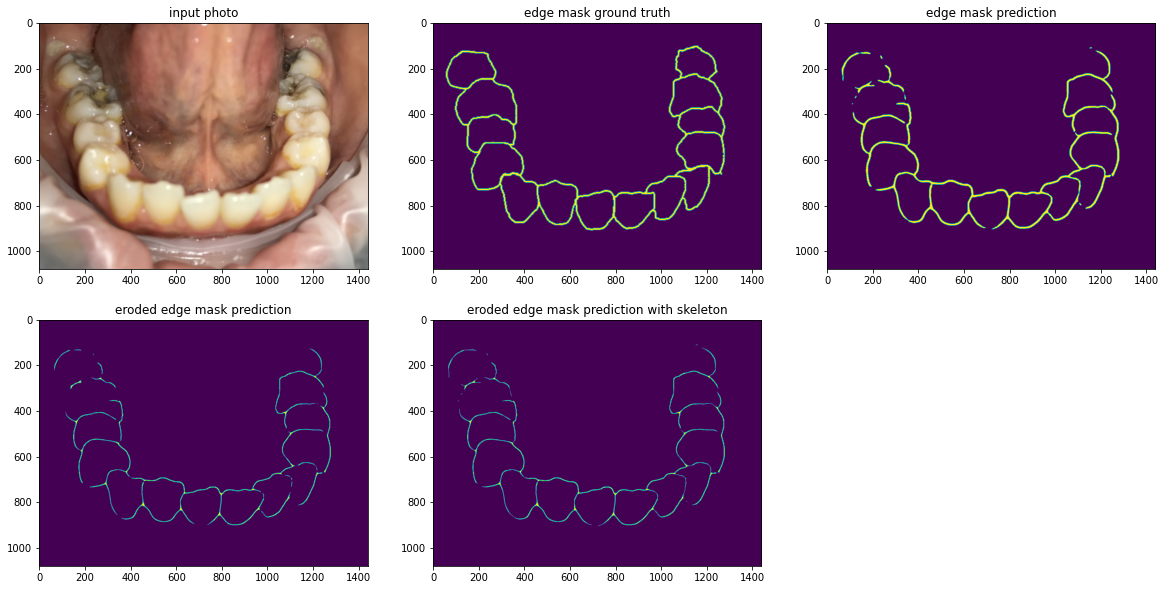

In [33]:
i = 6 # i-th mini-batch
j = 0 # j-th image in mini-batch
thre = 0.5
init_img_shape = (1080,1440,3)
init_lbl_shape = init_img_shape[:2]
print(valid_image[i*batch_size+j])
test_img, test_lbl = valid_dg[i]
pred_lbl = model.predict(test_img)
# pred_lbl = np.exp(pred_lbl) / (1.+np.exp(pred_lbl))
_test_img = skimage.transform.resize(test_img[j], init_img_shape)
_test_lbl = skimage.transform.resize(test_lbl[j], init_lbl_shape)
_pred_lbl = skimage.transform.resize(pred_lbl[j], init_lbl_shape)
plt.figure(figsize=(20,10))
plt.subplot(231)
plt.imshow(_test_img)
plt.title("input photo")
plt.subplot(232)
plt.imshow(_test_lbl)
plt.title("edge mask ground truth")
plt.subplot(233)
plt.imshow(_pred_lbl>thre)
plt.title("edge mask prediction")

_pred_skeleton = skimage.morphology.skeletonize(_pred_lbl>thre)

plt.subplot(234)
_pred_lbl = skimage.morphology.erosion(_pred_lbl, skimage.morphology.disk(EXPANSION_RATE))
plt.imshow(_pred_lbl>thre)
plt.title("eroded edge mask prediction")

plt.subplot(235)
plt.imshow(np.logical_or(_pred_lbl>thre, _pred_skeleton))
plt.title("eroded edge mask prediction with skeleton")

plt.show()

In [26]:
def calc_dsc(y, py):
    _tf = np.count_nonzero(np.logical_and(y, py))
    _sum = np.count_nonzero(y)+np.count_nonzero(py)
    return 2*_tf/_sum

def compute_avg_dsc(masks, pred_prob_map, thre=0.5, from_logits=False):
    pred_masks = pred_prob_map.copy()
    if from_logits == True:
        pred_masks = np.exp(pred_masks) / (1.+np.exp(pred_masks))
    pred_masks = pred_masks > thre
    dsc_list = [calc_dsc(masks[i], pred_masks[i]) for i in range(len(masks))]
    return np.mean(dsc_list)

def calc_recall_precision_F1score(y, py):
    _TP = np.count_nonzero(np.logical_and(y, py))
    _TN = np.count_nonzero(np.logical_and(1.-y, 1.-py))
    _FP = np.count_nonzero(np.logical_and(1.-y, py))
    _FN = np.count_nonzero(np.logical_and(y, 1.-py))
    _recall = _TP / (_TP + _FN)
    _precision = _TP / (_TP + _FP)
    _f1 = 2*_TP / (2*_TP + _FN + _FP)
    return _recall, _precision, _f1

def compute_avg_recall_precision_F1score(masks, pred_prob_map, thre=0.5, from_logits=False):
    pred_masks = pred_prob_map.copy()
    if from_logits == True:
        pred_masks = np.exp(pred_masks) / (1.+np.exp(pred_masks))
    pred_masks = pred_masks > thre
    ret_list = [calc_recall_precision_F1score(masks[i], pred_masks[i]) for i in range(len(masks))]
    return tuple(np.array(ret_list).mean(axis=0))

def save_pred_masks(pred_labels, file_names, mask_shape):
    assert len(pred_labels) == len(file_names)
    for i in range(len(file_names)):
        pred_prob_map = skimage.transform.resize(pred_labels[i], mask_shape)
        
        pred_prob_map = skimage.morphology.erosion(pred_prob_map, skimage.morphology.disk(EXPANSION_RATE))
        # preserved_mask = removeSmallCC(pred_prob_map>0.5, minNumConnectedPixel=100)
        # pred_prob_map = pred_prob_map * preserved_mask
        # pred_prob_map[pred_prob_map<=0.5] = 0.
        # pred_prob_map = np.clip(pred_prob_map, 0.0, 1.0)
        
        # pred_mask = skimage.morphology.skeletonize(pred_prob_map > 0.5)
        # pred_mask = skimage.morphology.binary_closing(pred_mask)
        
        pred_mask = pred_prob_map > 0.5
        pred_edge_img = (255. * pred_mask).astype(np.uint8)
        skimage.io.imsave(file_names[i], pred_edge_img)



def evaluate(model, save_pred_mask=False, mask_shape=(1080,1440)):
    valid_image, valid_label = get_data_filenames(VALID_PATH)
    if not LOW_MEMORY: # 内存充足
        valid_image, valid_label = read_data(VALID_PATH)
    valid_dg = DataGenerator(valid_image, valid_label, batch_size=1, train=False)
    # evaluate
    valid_pred_labels = model.predict(valid_dg)
    valid_labels = np.concatenate([img_lbl_pair[1] for img_lbl_pair in valid_dg], axis=0)
    # valid_avg_dsc = compute_avg_dsc(valid_labels, valid_pred_labels, thre=0.5, from_logits=False)
    # print("Average DICE coefficient of validation data: {:.4f}".format(valid_avg_dsc))
    _recall, _precision, _f1 = compute_avg_recall_precision_F1score(valid_labels, valid_pred_labels, thre=0.5, from_logits=False)
    print("[Validation Data] Average Recall: {:.4f}, Average precision: {:.4f}, Average F1-score: {:.4f}".format(_recall, _precision, _f1))
    if save_pred_mask == True:
        # save predicted edge mask
        valid_img_names = glob.glob(os.path.join(VALID_PATH, 'image', '*.png'))
        valid_pred_file_names = [os.path.join(VALID_PRED_PATH,os.path.basename(f)) for f in valid_img_names]
        save_pred_masks(valid_pred_labels, valid_pred_file_names, mask_shape)

In [36]:
if not os.path.exists(VALID_PRED_PATH):
    os.makedirs(VALID_PRED_PATH)
evaluate(model, save_pred_mask=True)

[Validation Data] Average Recall: 0.7411, Average precision: 0.7854, Average F1-score: 0.7618


C:\Users\11931\AppData\Local\Temp\ipykernel_12868\2896569511.py:48: UserWarning: ./dataWithPhoto/learning/fold5/test/pred-v12/符碧琦_219476_右侧咬合.png is a low contrast image
  skimage.io.imsave(file_names[i], pred_edge_img)
C:\Users\11931\AppData\Local\Temp\ipykernel_12868\2896569511.py:48: UserWarning: ./dataWithPhoto/learning/fold5/test/pred-v12/符碧琦_219476_正位像.png is a low contrast image
  skimage.io.imsave(file_names[i], pred_edge_img)
